<a href="https://colab.research.google.com/github/RPfrontiere/Food-Waste-Detection/blob/main/Detection_and_Segmentation_of_food's_waste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
%pip install ultralytics
%pip install timm
%pip install supervision

import supervision as sv
import timm
import ultralytics
ultralytics.checks()

import cv2 as cv #load YOLOV8 model
import os
import torch #load MIDAS model
import numpy as np
import requests
import matplotlib.pyplot as plt

import os
HOME = os.getcwd()
print("HOME:", HOME)


Ultralytics YOLOv8.2.59 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 30.2/78.2 GB disk)
HOME: /content


Load SAM model

In [13]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

SAM_MODEL = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.2 MB/s eta 0:00:00
/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [9]:
# Installazione delle librerie necessarie
!pip install git+https://github.com/ChaoningZhang/MobileSAM.git

# Creazione della directory weights
import os
HOME = os.getcwd()
os.makedirs(f"{HOME}/weights", exist_ok=True)

# Scaricamento dei pesi MobileSAM
!wget -q https://github.com/ChaoningZhang/MobileSAM/raw/master/weights/mobile_sam.pt -P {HOME}/weights

# Verifica del percorso dei pesi
CHECKPOINT_PATH = os.path.join(HOME, "weights", "mobile_sam.pt")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

# Configurazione del dispositivo
import torch
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Caricamento del modello MobileSAM
from mobile_sam import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator
MODEL_TYPE = "vit_t"

SAM_MODEL = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

  Cloning https://github.com/ChaoningZhang/MobileSAM.git to /tmp/pip-req-build-ho59s97n
  Running command git clone --filter=blob:none --quiet https://github.com/ChaoningZhang/MobileSAM.git /tmp/pip-req-build-ho59s97n
  Resolved https://github.com/ChaoningZhang/MobileSAM.git to commit c12dd83cbe26dffdcc6a0f9e7be2f6fb024df0ed
  Preparing metadata (setup.py) ... done
/content/weights/mobile_sam.pt ; exist: True


Load YOLO model

In [10]:
from ultralytics import YOLO
yolo_model = YOLO('yolov8n.pt')  # load a pretrained model (recommended for training)

100%|██████████| 6.25M/6.25M [00:00<00:00, 218MB/s]


Load Depth Estimation model (MIDAS)

In [11]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)
midas = torch.hub.load("intel-isl/MiDaS", model_type)

Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_large_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_large_384.pt
100%|██████████| 1.28G/1.28G [00:06<00:00, 203MB/s]


Testing models

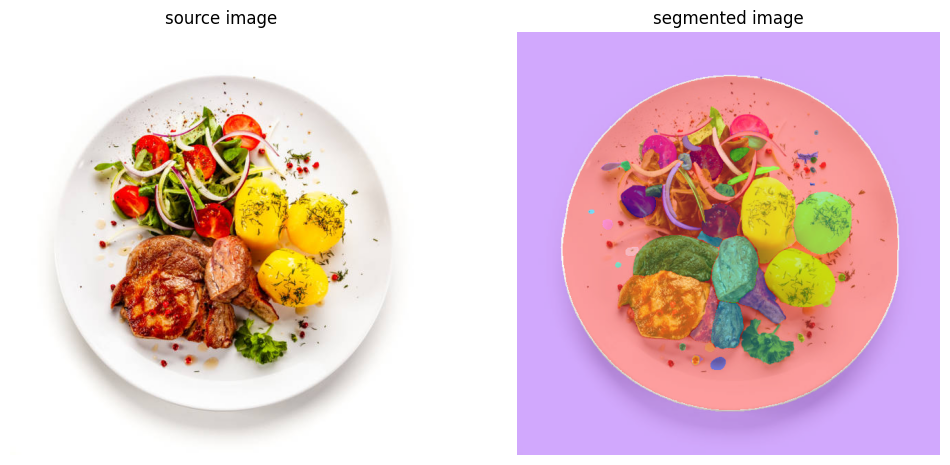

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


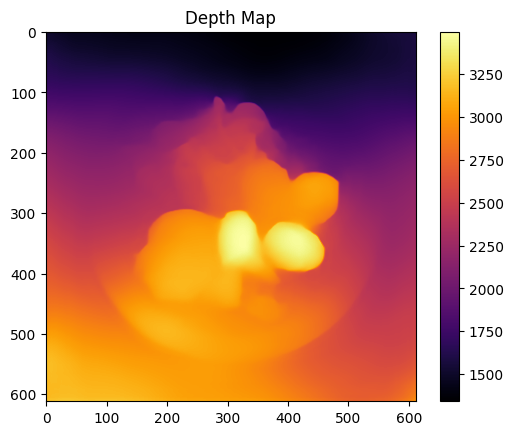

In [24]:
def load_image_from_url(url):
    response = requests.get(url)
    image = np.asarray(bytearray(response.content), dtype="uint8")
    image = cv.imdecode(image, cv.IMREAD_COLOR)
    return image

# Caricamento dell'immagine di test
image_url = "https://media.istockphoto.com/id/1190330112/photo/fried-pork-and-vegetables-on-white-background.jpg?s=612x612&w=0&k=20&c=TzvLLGGvPAmxhKJ6fz91UGek-zLNNCh4iq7MVWLnFwo="
#image_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRxqk9ETQhGwqt2RTr3CA3udji9gxp7TZeT4qiFGucmy7Hzq-MjXIeTpJW0izeWB45Ns_E&usqp=CAU"
image = load_image_from_url(image_url)

# Segmentazione del cibo con SAM
mask_generator = SamAutomaticMaskGenerator(SAM_MODEL)
sam_result = mask_generator.generate(image)
#print(sam_result)

import supervision as sv
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result=sam_result)
annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
sv.plot_images_grid(
    images=[image, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

# Stima della profondità con MiDaS
def estimate_depth(image, midas):
    transform = torch.hub.load("intel-isl/MiDaS", "transforms").dpt_transform
    input_batch = transform(image).to(DEVICE)
    with torch.no_grad():
        prediction = midas(input_batch)
        prediction = torch.nn.functional.interpolate(prediction.unsqueeze(1), size=image.shape[:2], mode="bicubic", align_corners=False).squeeze()
    depth_map = prediction.cpu().numpy()
    return depth_map

# Caricamento del modello MiDaS
midas.to(DEVICE)
#midas = torch.hub.load("intel-isl/MiDaS", "MiDaS").to(DEVICE)
midas.eval()

depth_map = estimate_depth(image, midas)

# Visualizzazione della mappa di profondità
plt.imshow(depth_map, cmap='inferno')
plt.title("Depth Map")
plt.colorbar()
plt.show()